In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np                                                              
import pandas as pd      
import geopandas as gpd
import matplotlib as mpl        
from libpysal.weights import KNN,Queen
import spreg

In [2]:
data = pd.read_csv("Data/voting_2021.csv")
us = gpd.read_file("Data/County_shp_2018/County_shp_2018.shp")
us = us.to_crs('ESRI:102008')
state = us.dissolve(by='STATEFP').geometry.boundary
data = gpd.GeoDataFrame(data.merge(us[['geoid_int','geometry']],left_on='county_id',right_on='geoid_int'))

In [3]:
data.shape

(3108, 24)

In [4]:
names = ['sex_ratio', 'pct_black', 'pct_hisp','pct_bach','median_income',
     'pct_65_over', 'pct_age_18_29','gini','pct_manuf','ln_pop_den','pct_3rd_party',
         'turn_out','pct_fb','pct_uninsured']

In [5]:
y = data.new_pct_dem.values
X = data[names].values

In [6]:
y = (y-y.mean())/y.std()
X = (X-X.mean(axis=0))/X.std(axis=0)

### SEM Queen

In [7]:
w1 = Queen.from_dataframe(data)
w1.transform = 'R'

/Users/ziqi/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
/Users/ziqi/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))


('WARNING: ', 807, ' is an island (no neighbors)')
('WARNING: ', 2323, ' is an island (no neighbors)')


/Users/ziqi/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 807, 2323.
  warnings.warn(message)


In [8]:
sem_q = spreg.ML_Error(y, X, w=w1, name_y='y', name_x=names)
print(sem_q.summary)

/Users/ziqi/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           y                Number of Observations:        3108
Mean dependent var  :     -0.0000                Number of Variables   :          15
S.D. dependent var  :      1.0002                Degrees of Freedom    :        3093
Pseudo R-squared    :      0.4886
Sigma-square ML     :       0.113                Log likelihood        :   -1367.720
S.E of regression   :       0.336                Akaike info criterion :    2765.439
                                                 Schwarz criterion     :    2856.065

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [9]:
TSS = np.sum((y - y.mean())**2)
RSS = np.sum(sem_q.e_filtered**2)
print(1 - RSS/TSS)

0.8872275530989512


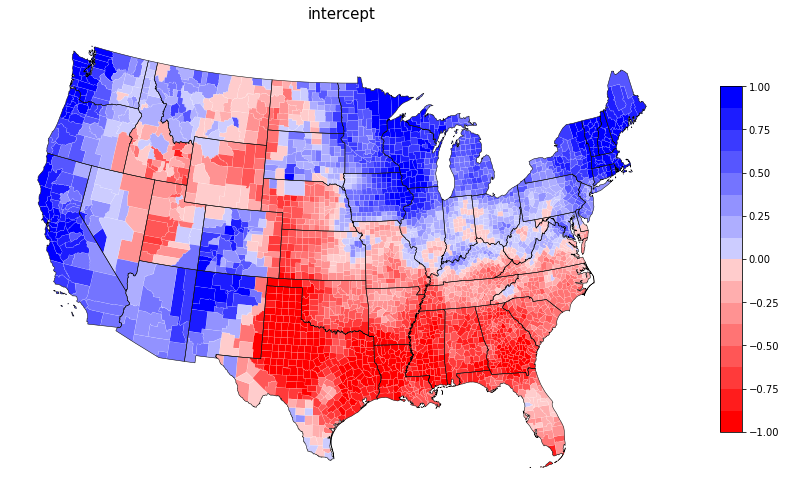

In [10]:
from matplotlib import cm,colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm,colors

cmap = np.vstack([cm.get_cmap("bwr_r")(np.linspace(0,0.4,8)),
                 cm.get_cmap("bwr_r")(np.linspace(0.6,1,8))])

cmap = mpl.colors.ListedColormap(cmap)
    
ax = data.plot(column=(sem_q.u-sem_q.e_filtered).reshape(-1),vmin=-1,vmax=1,figsize=(12,12),cmap=cmap,
                  linewidth=0.1,edgecolor='white')

state.plot(color=None,ax=ax,linewidth=0.5,edgecolor='black')


plt.axis('off')
plt.title('intercept',fontsize=15,)
    
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
fig = ax.get_figure()
cax = fig.add_axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

plt.savefig('SEM_intercept_Queen',dpi=600,bbox_inches='tight')


### SEM KNN

In [11]:
import warnings
warnings.filterwarnings('ignore')

sae_list = []
sae_accuracy = []
aic_list = []

iter = range(4,40,2)

for k in iter:
    
    w = KNN.from_dataframe(data, k=k)
    w.transform = 'R'
    
    sem = spreg.ML_Error(y, X, w=w, name_y='y', name_x=names)
    
    sae = sem.u - sem.e_filtered + sem.betas[0]
    
    sae_list.append(sae)
    
    aic_list.append(sem.aic)

Text(0, 0.5, 'AIC')

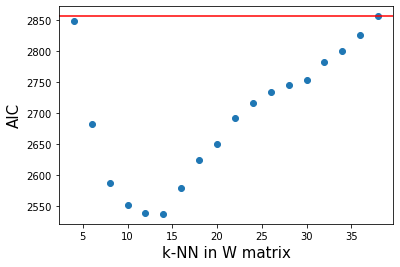

In [12]:
plt.scatter(iter, aic_list)
plt.axhline(y=sem.aic, color='r', linestyle='-')
plt.xlabel("k-NN in W matrix",fontsize=15)
plt.ylabel("AIC",fontsize=15)

In [13]:
w_knn = KNN.from_dataframe(data, k=14)
w_knn.transform = 'R'
sem = spreg.ML_Error(y, X, w=w_knn, name_y='y', name_x=names)

In [14]:
TSS = np.sum((y - y.mean())**2)
RSS = np.sum(sem.e_filtered**2)
print(1 - RSS/TSS)

0.8830656304749022


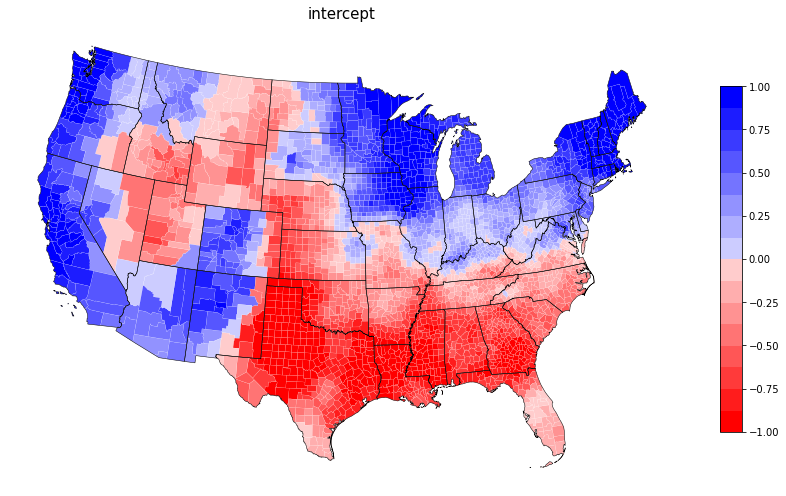

In [15]:
from matplotlib import cm,colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm,colors

cmap = np.vstack([cm.get_cmap("bwr_r")(np.linspace(0,0.4,8)),
                 cm.get_cmap("bwr_r")(np.linspace(0.6,1,8))])

cmap = mpl.colors.ListedColormap(cmap)
    
ax = data.plot(column=(sem.u-sem.e_filtered).reshape(-1),vmin=-1,vmax=1,figsize=(12,12),cmap=cmap,
                  linewidth=0.1,edgecolor='white')

state.plot(color=None,ax=ax,linewidth=0.5,edgecolor='black')


plt.axis('off')
plt.title('intercept',fontsize=15,)
    
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
fig = ax.get_figure()
cax = fig.add_axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

plt.savefig('SEM_intercept_KNN',dpi=600,bbox_inches='tight')